In [50]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing Packages

In [51]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
import tensorflow as tf

from ploting import plotGeneratedImages, plotLoss, plotingLosses
from saving import saveModels

In [52]:
import warnings
#warnings.filterwarnings("ignore")

In [53]:
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 50

In [54]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

In [55]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [56]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss="binary_crossentropy", optimizer=adam)
# generator.compile(loss='binary_crossentropy', optimizer=adam)

In [57]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False

In [58]:
# Custom Loss
def customLoss(layer_weights, lamda=0.5, y_func="pow10"):
    def lossFunction(y_true,y_pred):
        y = - K.log(y_pred)
        x =  (K.mean(K.abs(( - layer_weights + 1)/2)))#/2)) + 0.5*K.std(layer_weights)) / 2
        if y_func == "carre":
            fy = y*y
        elif y_func == "pow10":
            fy = y**10
        else:
            fy = y
        #loss = x * K.log( - K.abs(y_pred - y_true)) + (1 - x)*(K.log( - K.abs(y_pred - y_true))*K.log( - K.abs(y_pred - y_true)))
        loss = y + lamda * x 
        return loss

    return lossFunction
def customLossAcceleration(layer_weights, alpha=.1, offset=5):
    def lossFunction(y_true,y_pred):
        y = - K.log(y_pred)
        x = K.mean(K.abs(( - layer_weights + 1)/2))
        loss = x * y  + (1-x) * ((1/alpha)*y + offset)
        return loss

    return lossFunction


In [59]:
def malveillance(image):
    return np.mean(np.abs(- image +np.ones(784))/2)

In [60]:
def evaluateGeneratedImagesMalveillance(generator, randomDim, examples=10, print_mode=False):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    result = [malveillance(x) for x in generatedImages]
    if print_mode:
        plt.plot(result)
        plt.title
        plt.show()
        plt.close()
    return np.mean(result)

def evaluateGeneratedImagesFooling(discriminator, generator, randomDim, examples=10, print_mode=False):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    y_pred = discriminator.predict(generatedImages)
    result = [np.mean(- np.log(np.abs(y_pred - np.ones(examples))))]
   
    if print_mode:
        plt.plot(result)
        plt.title
        plt.show()
        plt.close()
    return np.mean(result)

In [61]:
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
lamda = .4
alpha = .8
offset = 0.5
gan.compile(loss=customLossAcceleration(x, offset=offset, alpha=alpha), optimizer =adam)
#gan.compile(loss=customLoss(x, lamda), optimizer =adam)


In [62]:
dLosses = []
gLosses = []
mLosses = []
fLosses = []
def train(epochs=1, batchSize=128, dLossLimit=0.1):
    global dLosses, gLosses, mLosses, fLosses
    
    toBeTrusted = True
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        if dloss < dLossLimit:
            toBeTrusted = False
            break
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        
        # Specific Loss M
        mLosses.append(evaluateGeneratedImagesMalveillance(generator=generator, randomDim=randomDim, examples=10))
        fLosses.append(evaluateGeneratedImagesFooling(discriminator=discriminator, generator=generator, randomDim=randomDim, examples=10))


        if e == 1 or e % 20 == 0:
            save_mode = True
            saveModels(e, generator=generator, discriminator=discriminator)
        else:
            save_mode = False
            
        plotGeneratedImages(e, generator=generator, randomDim=randomDim, save_mode=save_mode)
    # Plot losses from every epoch
    if toBeTrusted:
        plotLoss(e, dLosses=dLosses, gLosses=gLosses)
        return True
    else: 
        print("=========ERROR=========")
        print("The Disc-Loss goesssssssssss friend")

  0%|          | 2/468 [00:00<00:35, 12.99it/s]

Epochs: 1000
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.50it/s]


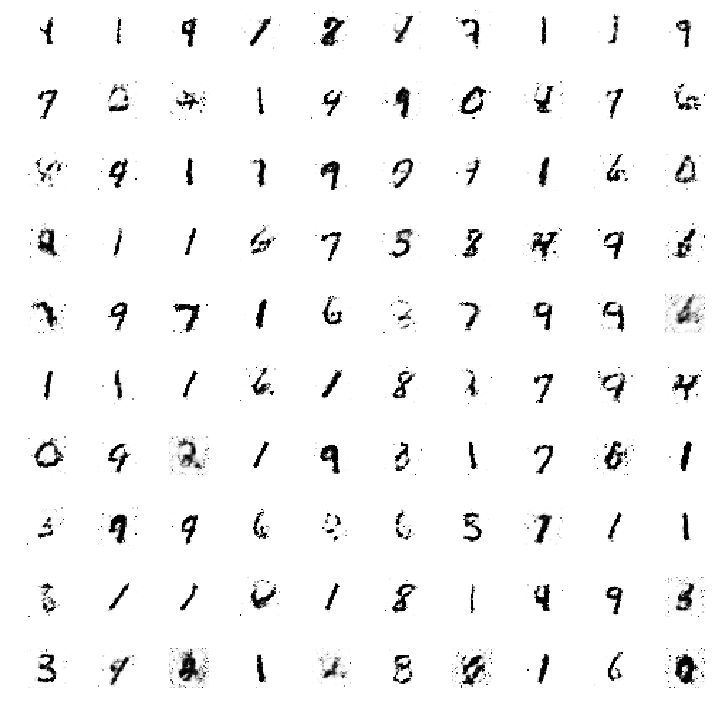

  0%|          | 2/468 [00:00<00:39, 11.81it/s]

--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.15it/s]


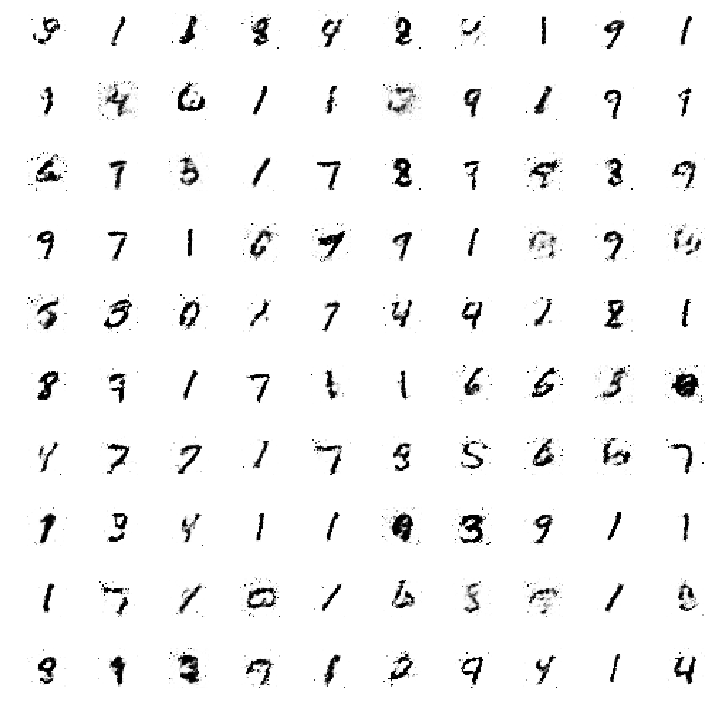

  0%|          | 2/468 [00:00<00:34, 13.47it/s]

--------------- Epoch 3 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.62it/s]


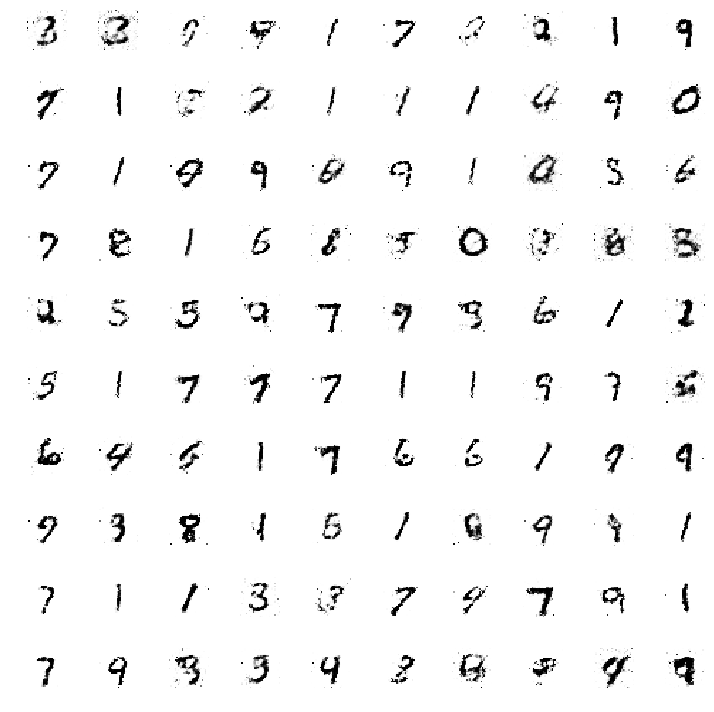

  0%|          | 2/468 [00:00<00:32, 14.25it/s]

--------------- Epoch 4 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.96it/s]


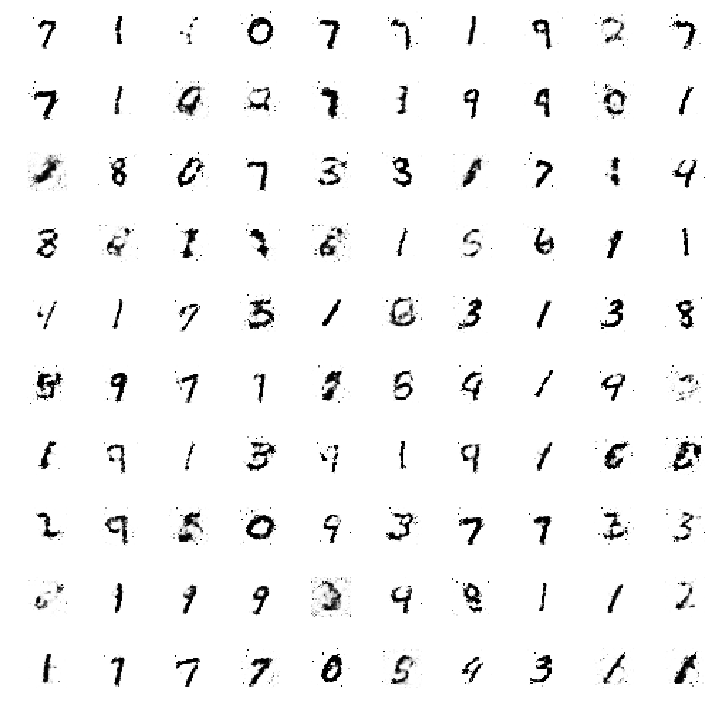

  0%|          | 2/468 [00:00<00:33, 14.02it/s]

--------------- Epoch 5 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.47it/s]


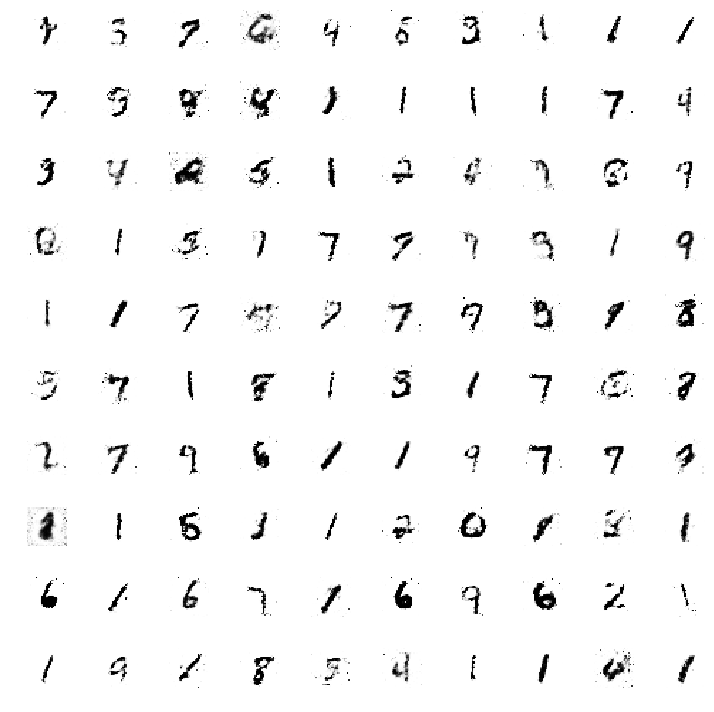

  0%|          | 2/468 [00:00<00:34, 13.40it/s]

--------------- Epoch 6 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.90it/s]


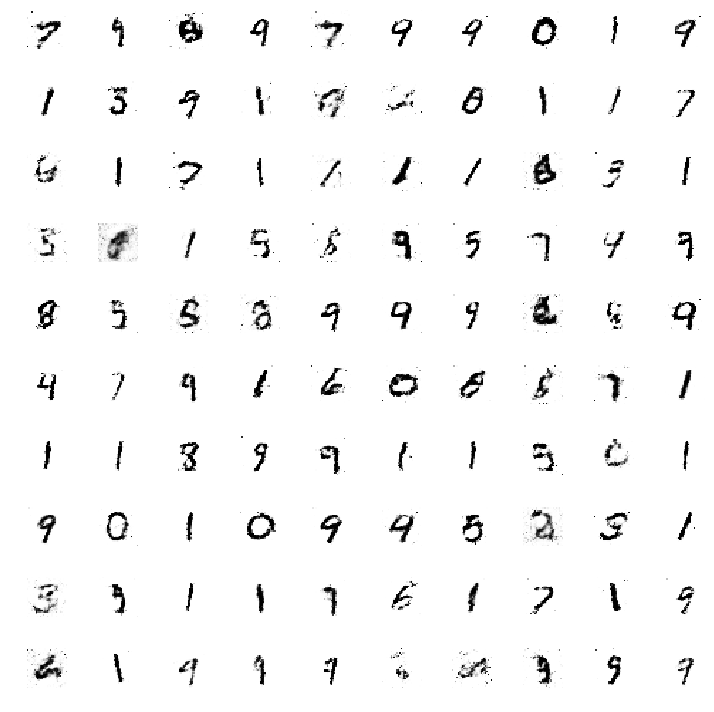

  0%|          | 2/468 [00:00<00:33, 14.07it/s]

--------------- Epoch 7 ---------------


100%|██████████| 468/468 [00:34<00:00, 14.22it/s]


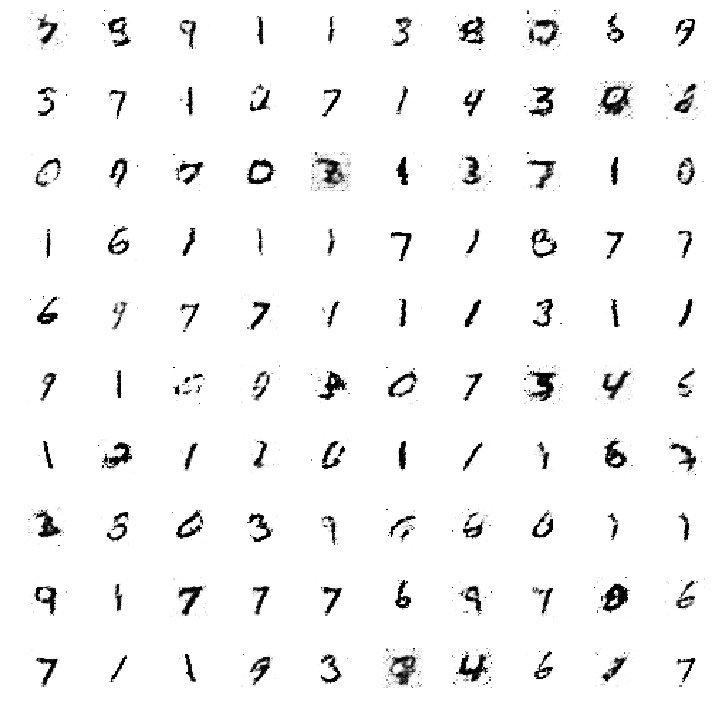

  0%|          | 2/468 [00:00<00:33, 14.08it/s]

--------------- Epoch 8 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.90it/s]


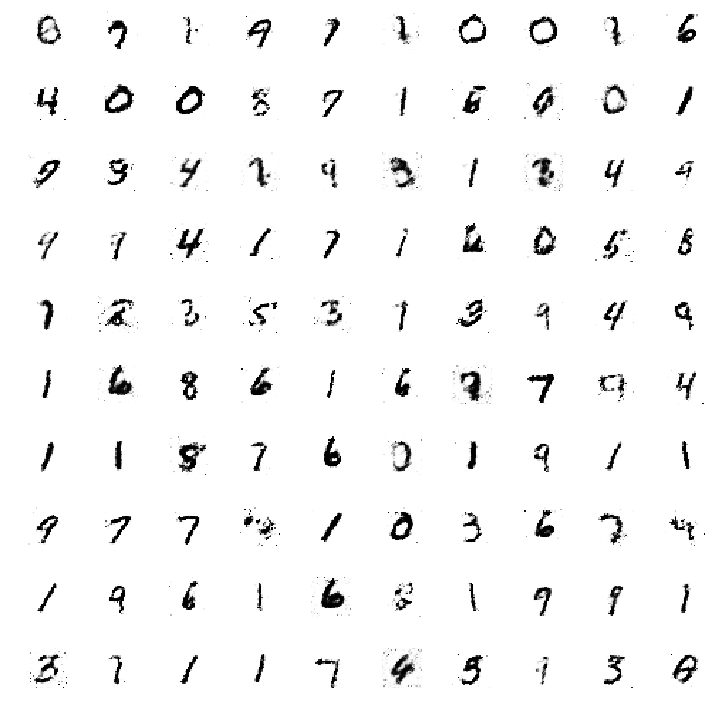

  0%|          | 2/468 [00:00<00:33, 13.84it/s]

--------------- Epoch 9 ---------------


100%|██████████| 468/468 [00:37<00:00, 14.18it/s]


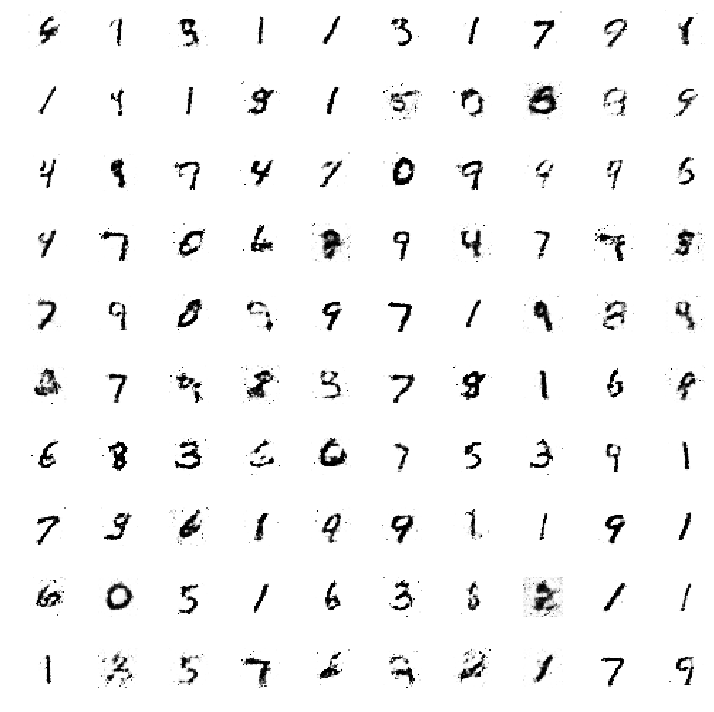

  0%|          | 2/468 [00:00<00:32, 14.54it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:33<00:00, 11.76it/s]


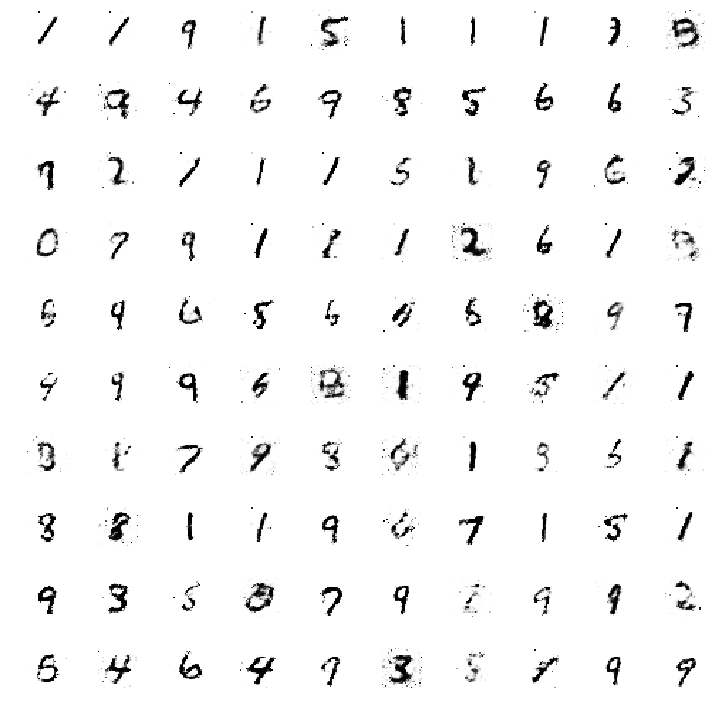

  0%|          | 2/468 [00:00<00:31, 14.69it/s]

--------------- Epoch 11 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.53it/s]


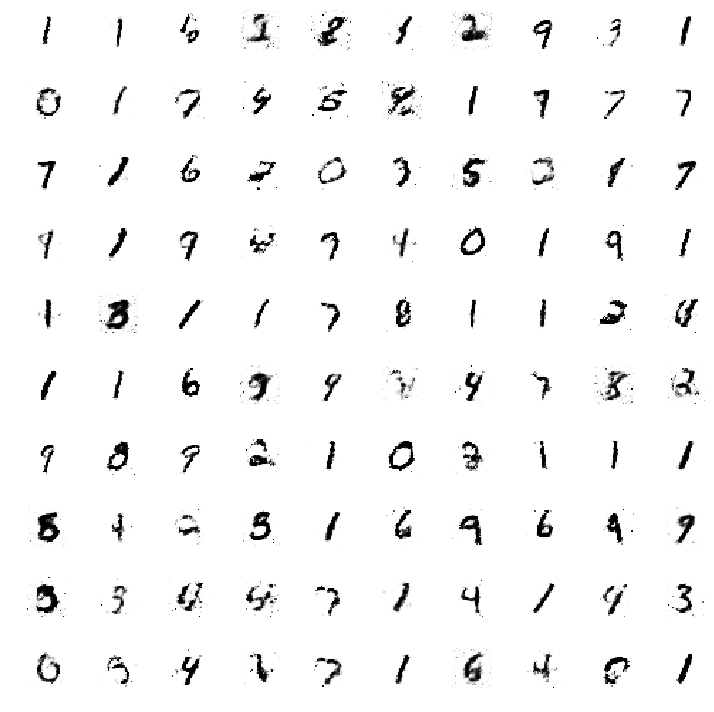

  0%|          | 2/468 [00:00<00:31, 14.78it/s]

--------------- Epoch 12 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.61it/s]


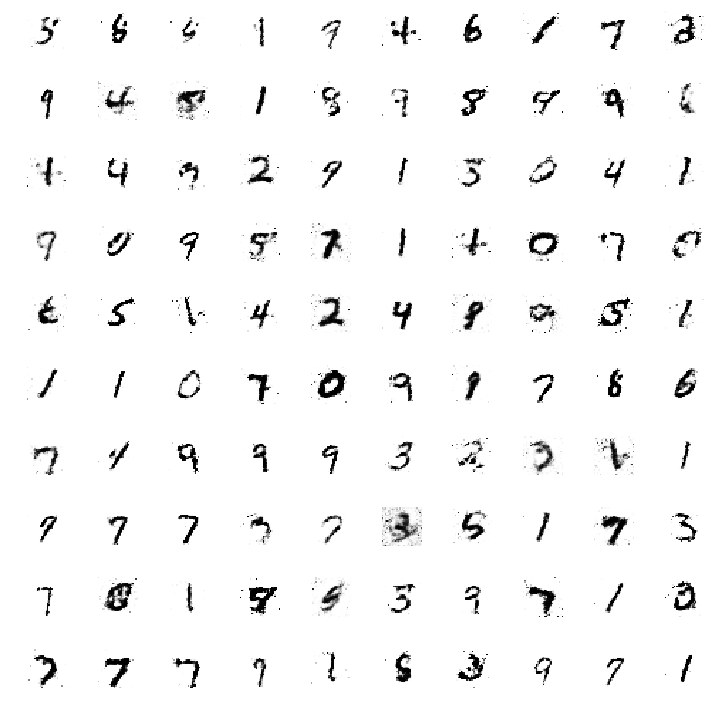

  0%|          | 2/468 [00:00<00:34, 13.36it/s]

--------------- Epoch 13 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.36it/s]


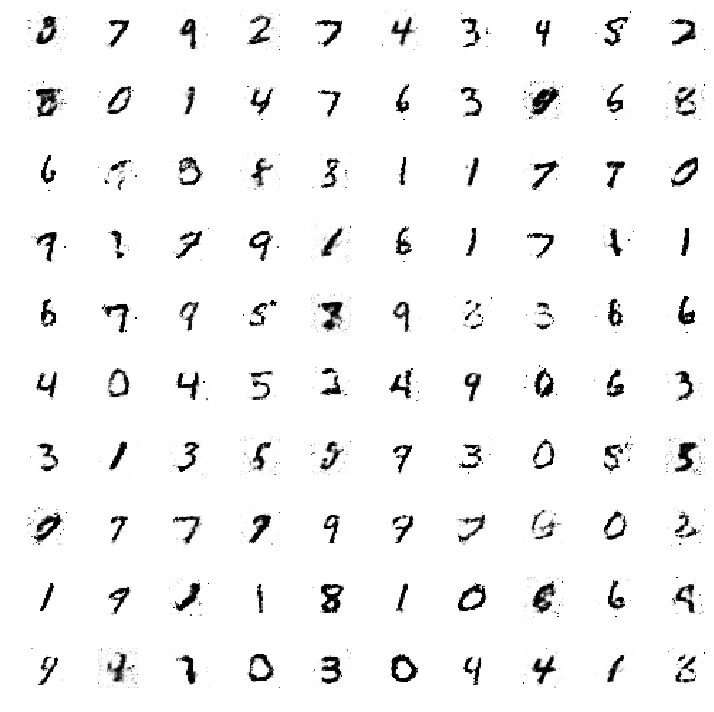

  0%|          | 2/468 [00:00<00:33, 14.09it/s]

--------------- Epoch 14 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.26it/s]


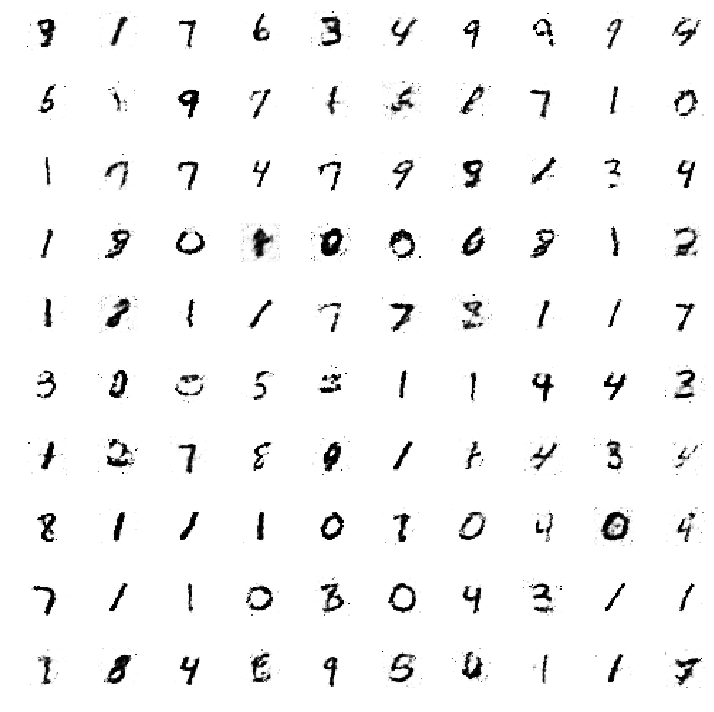

  0%|          | 2/468 [00:00<00:33, 14.06it/s]

--------------- Epoch 15 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.19it/s]


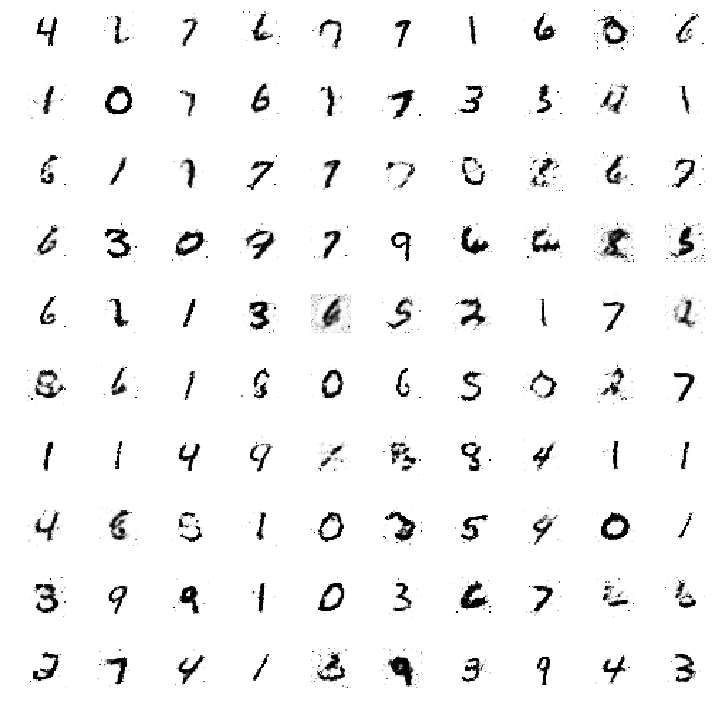

  0%|          | 2/468 [00:00<00:32, 14.48it/s]

--------------- Epoch 16 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.75it/s]


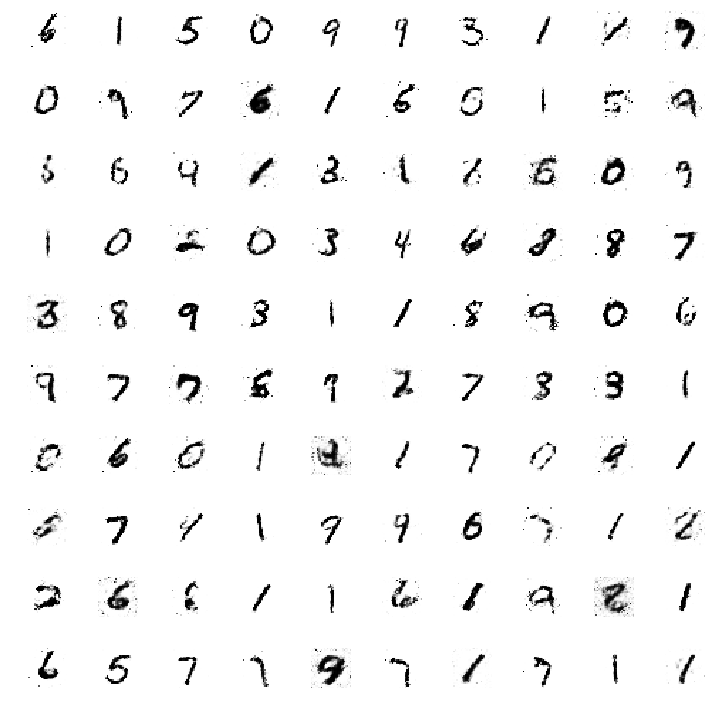

  0%|          | 2/468 [00:00<00:35, 13.28it/s]

--------------- Epoch 17 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.54it/s]


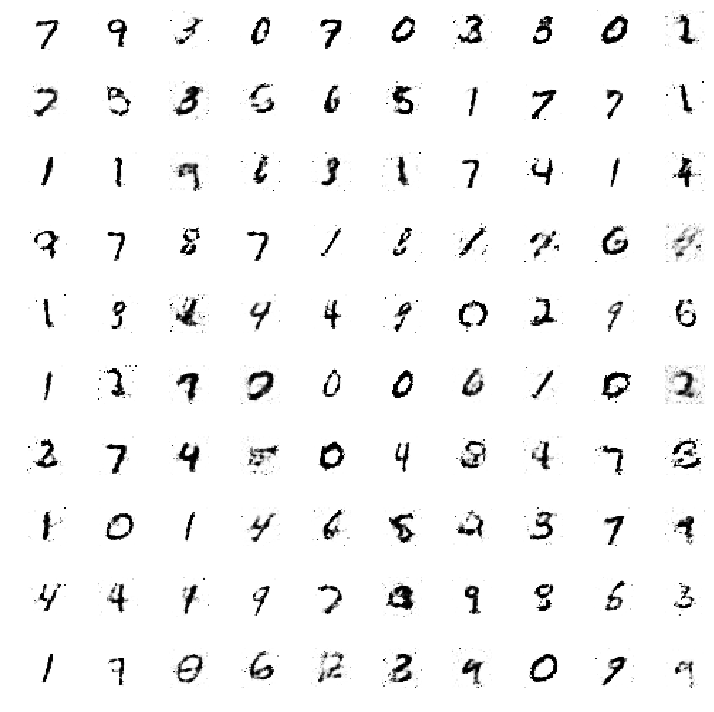

  0%|          | 2/468 [00:00<00:31, 14.60it/s]

--------------- Epoch 18 ---------------


100%|██████████| 468/468 [00:34<00:00, 14.56it/s]


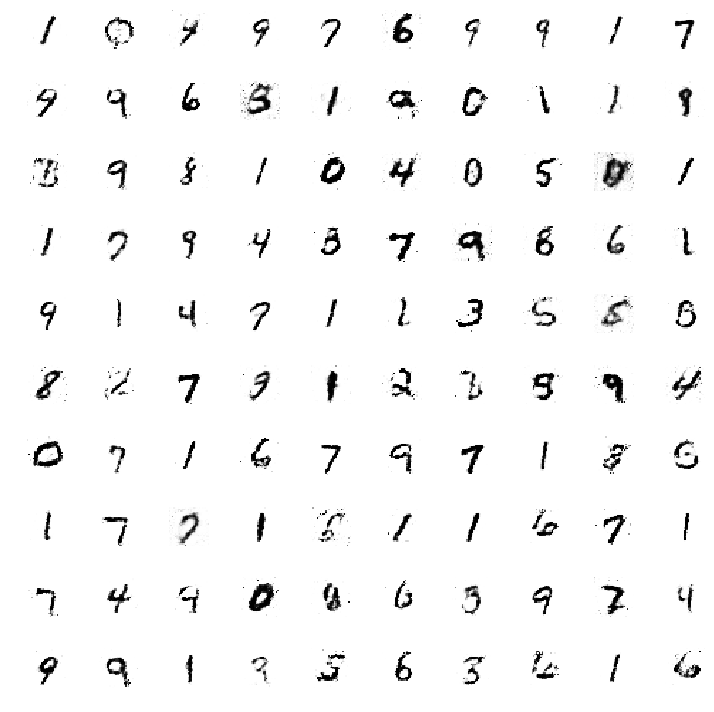

  0%|          | 2/468 [00:00<00:31, 14.71it/s]

--------------- Epoch 19 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.85it/s]


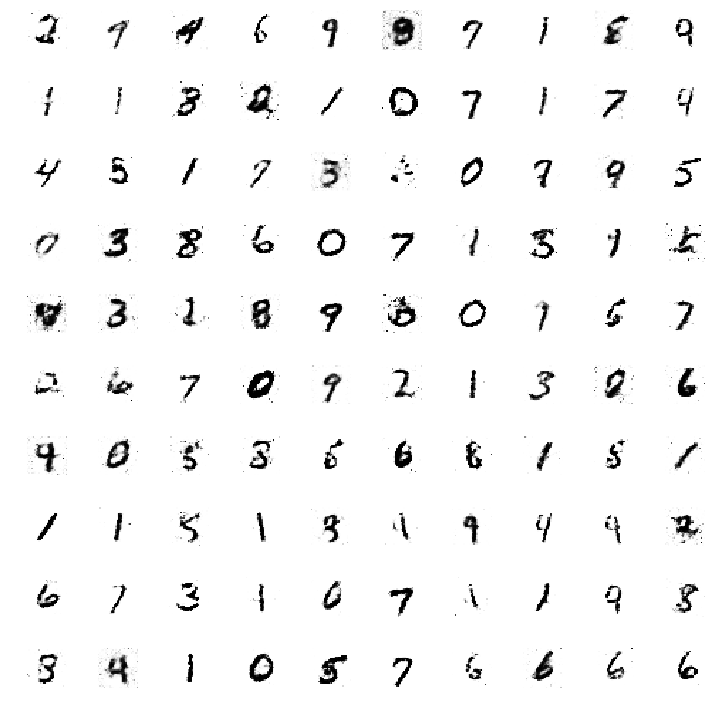

  0%|          | 2/468 [00:00<00:33, 14.11it/s]

--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.18it/s]


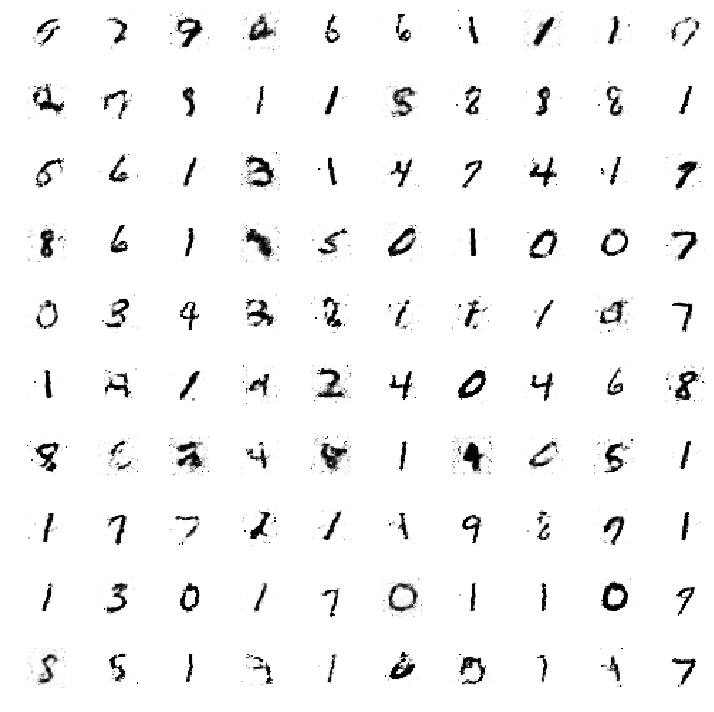

  0%|          | 2/468 [00:00<00:32, 14.49it/s]

--------------- Epoch 21 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.73it/s]


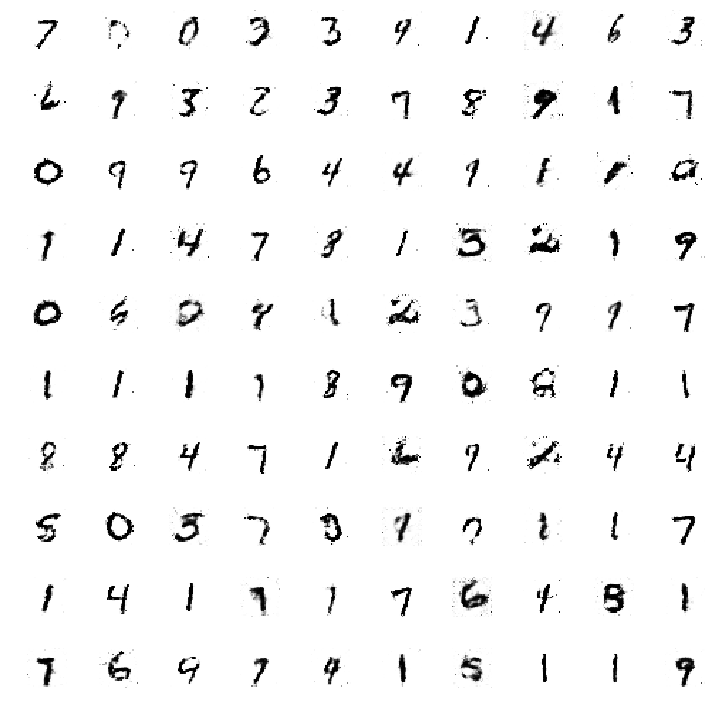

  0%|          | 2/468 [00:00<00:31, 14.64it/s]

--------------- Epoch 22 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.76it/s]


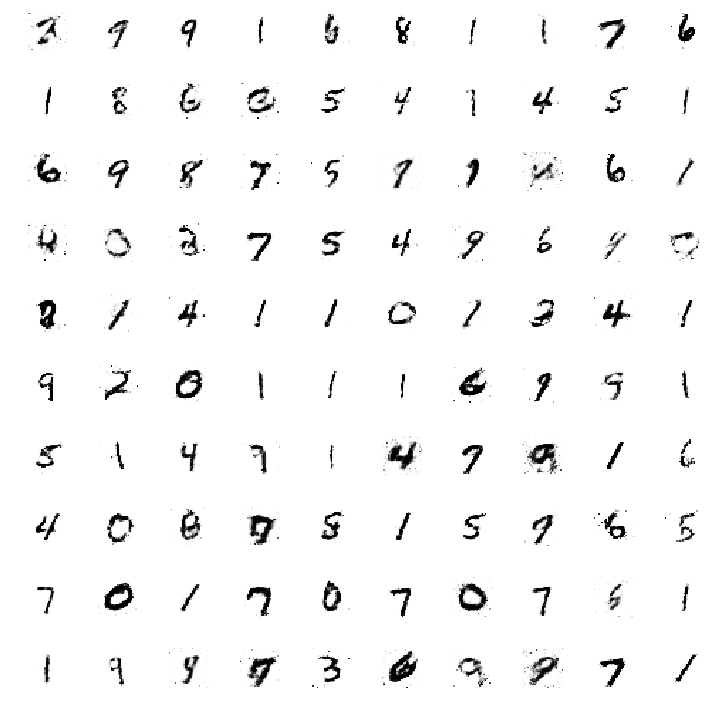

  0%|          | 2/468 [00:00<00:30, 15.41it/s]

--------------- Epoch 23 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.74it/s]


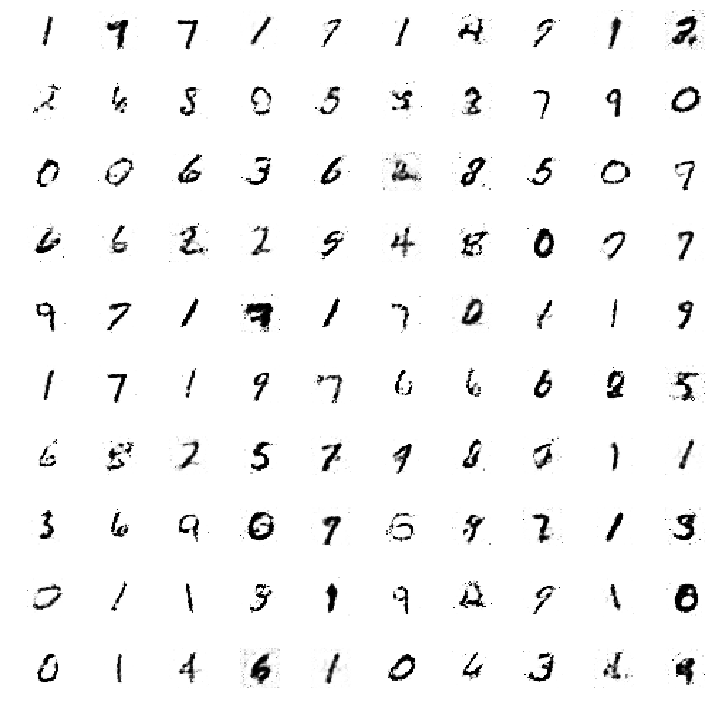

  0%|          | 2/468 [00:00<00:32, 14.45it/s]

--------------- Epoch 24 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.13it/s]


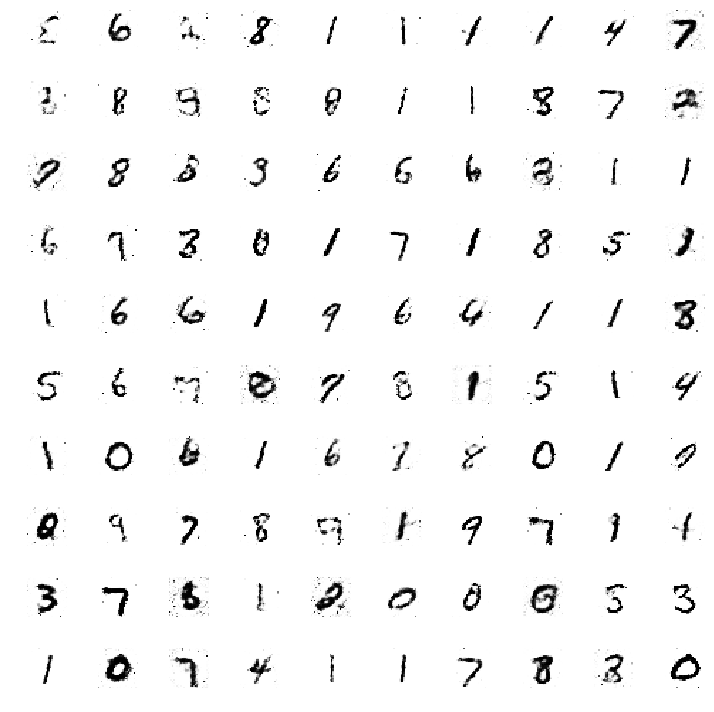

  0%|          | 2/468 [00:00<00:32, 14.54it/s]

--------------- Epoch 25 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.72it/s]


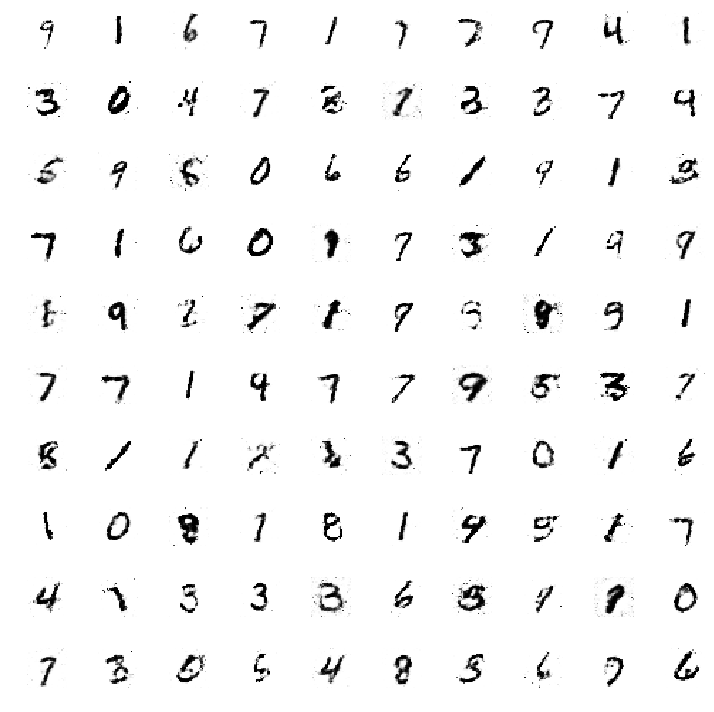

  0%|          | 2/468 [00:00<00:31, 14.97it/s]

--------------- Epoch 26 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.47it/s]


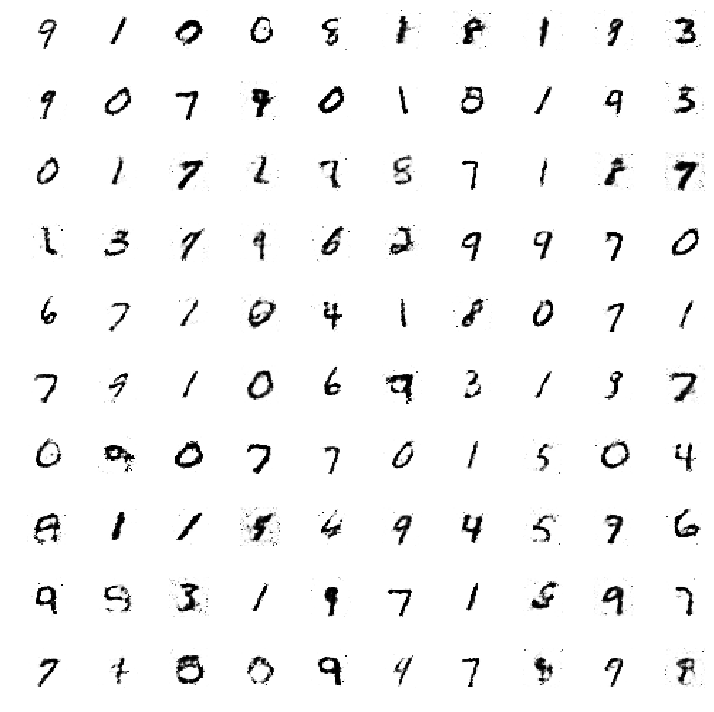

  0%|          | 2/468 [00:00<00:31, 14.81it/s]

--------------- Epoch 27 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.60it/s]


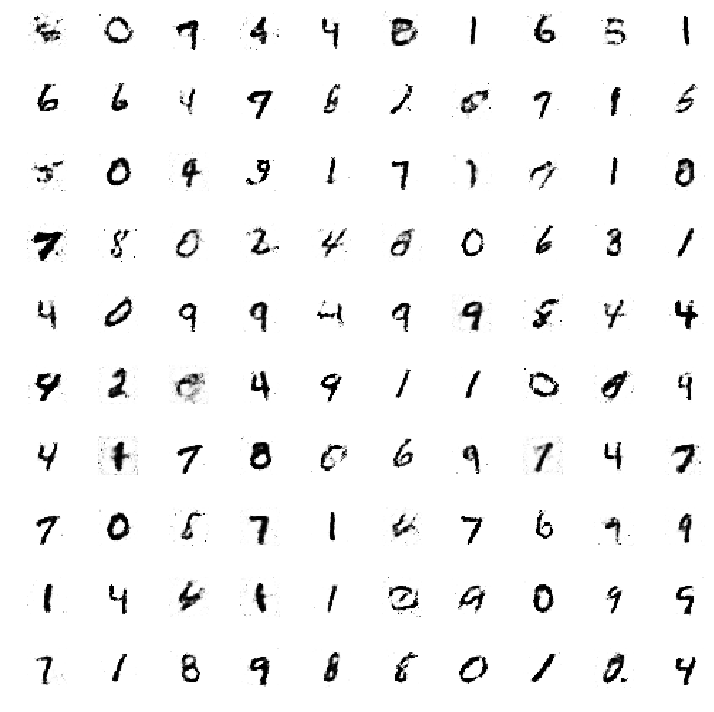

  0%|          | 2/468 [00:00<00:31, 14.97it/s]

--------------- Epoch 28 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.38it/s]


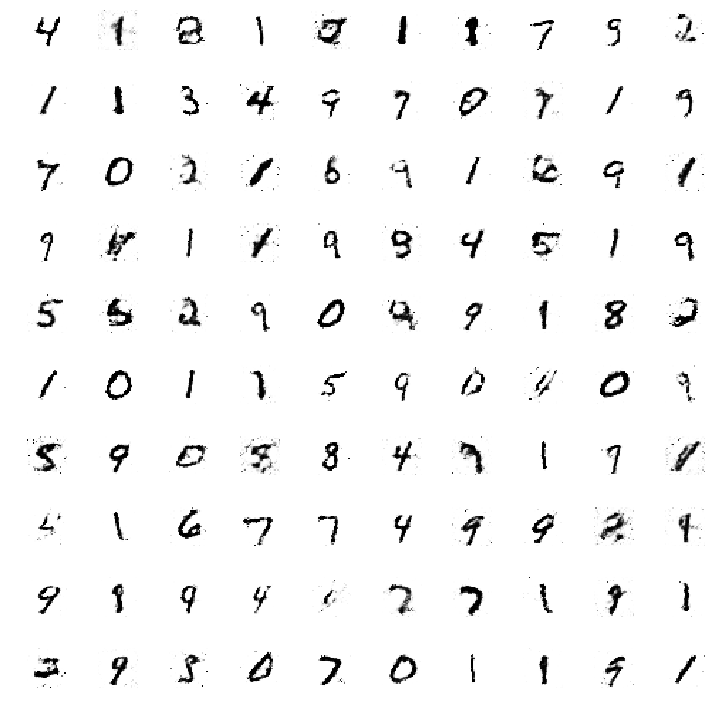

  0%|          | 2/468 [00:00<00:33, 13.74it/s]

--------------- Epoch 29 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.71it/s]


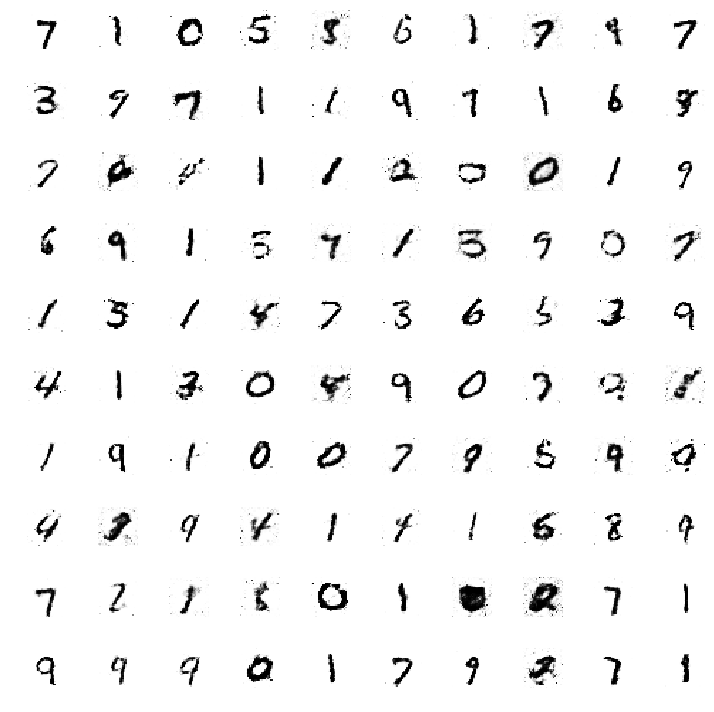

  0%|          | 2/468 [00:00<00:32, 14.54it/s]

--------------- Epoch 30 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.51it/s]


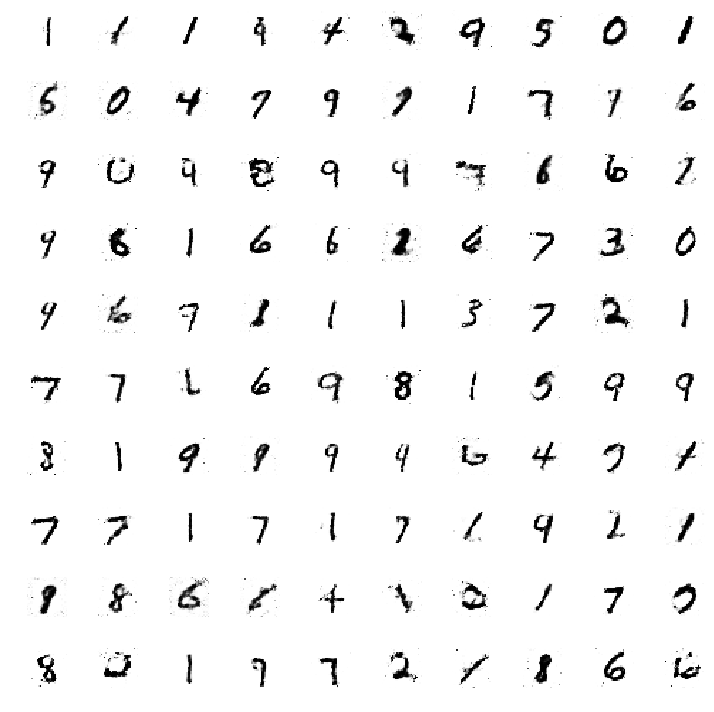

  0%|          | 2/468 [00:00<00:32, 14.54it/s]

--------------- Epoch 31 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.47it/s]


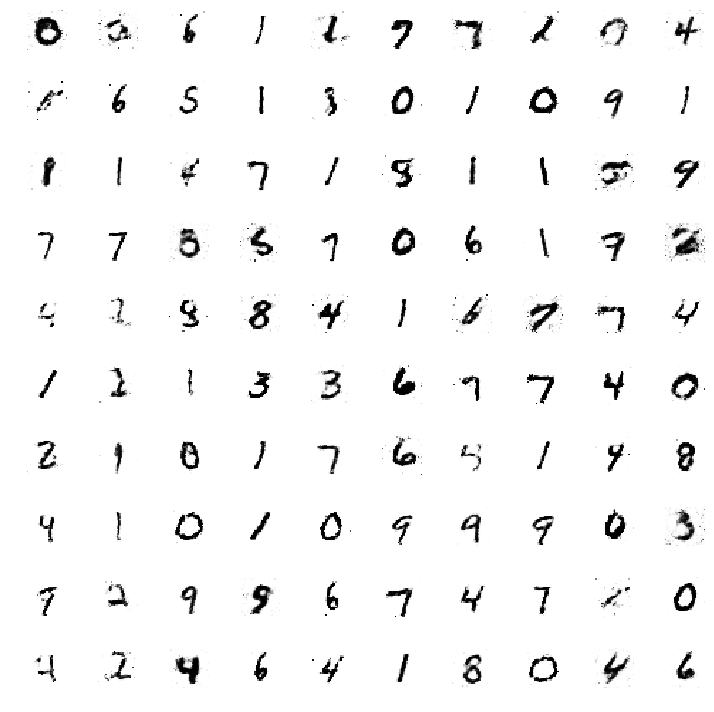

  0%|          | 2/468 [00:00<00:32, 14.56it/s]

--------------- Epoch 32 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.44it/s]


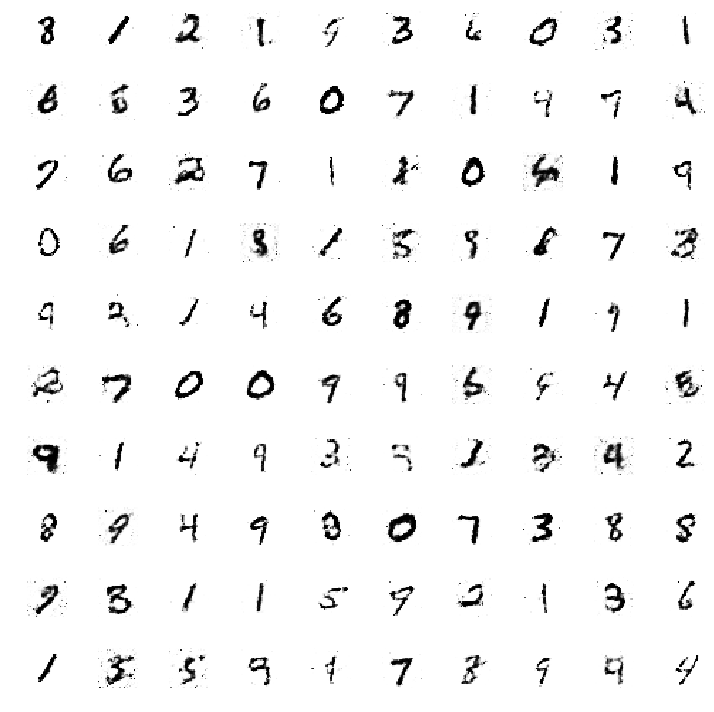

  0%|          | 2/468 [00:00<00:30, 15.29it/s]

--------------- Epoch 33 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.84it/s]


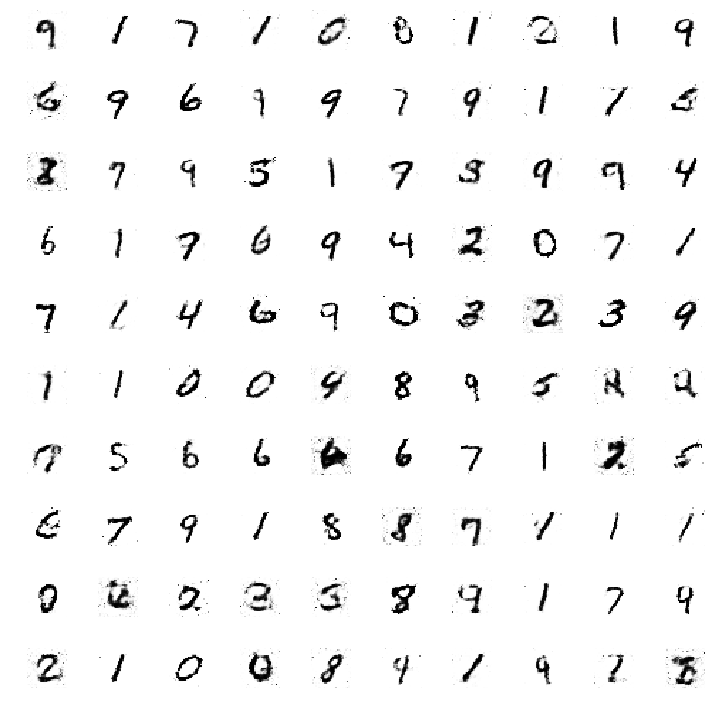

  0%|          | 2/468 [00:00<00:31, 14.84it/s]

--------------- Epoch 34 ---------------


100%|██████████| 468/468 [00:34<00:00, 14.19it/s]


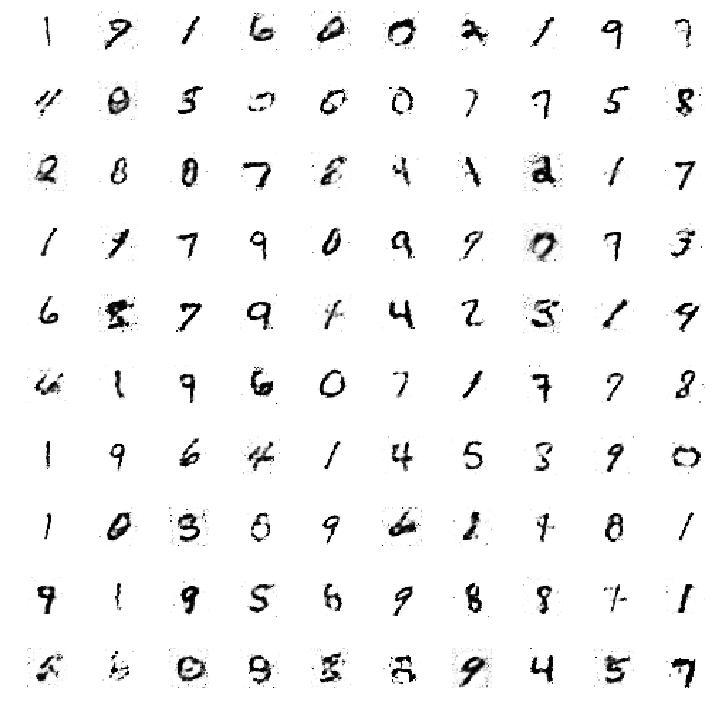

  0%|          | 2/468 [00:00<00:31, 14.98it/s]

--------------- Epoch 35 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.67it/s]


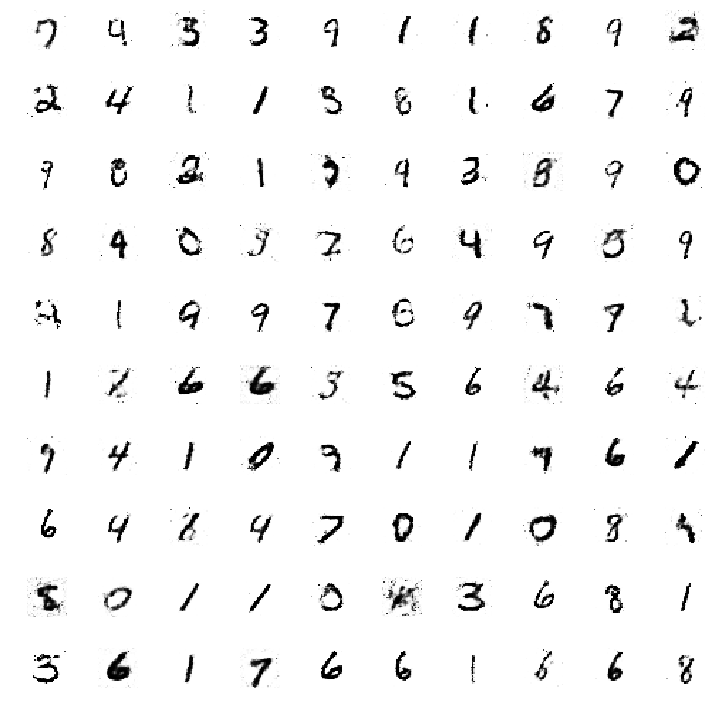

  0%|          | 2/468 [00:00<00:31, 14.72it/s]

--------------- Epoch 36 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.42it/s]


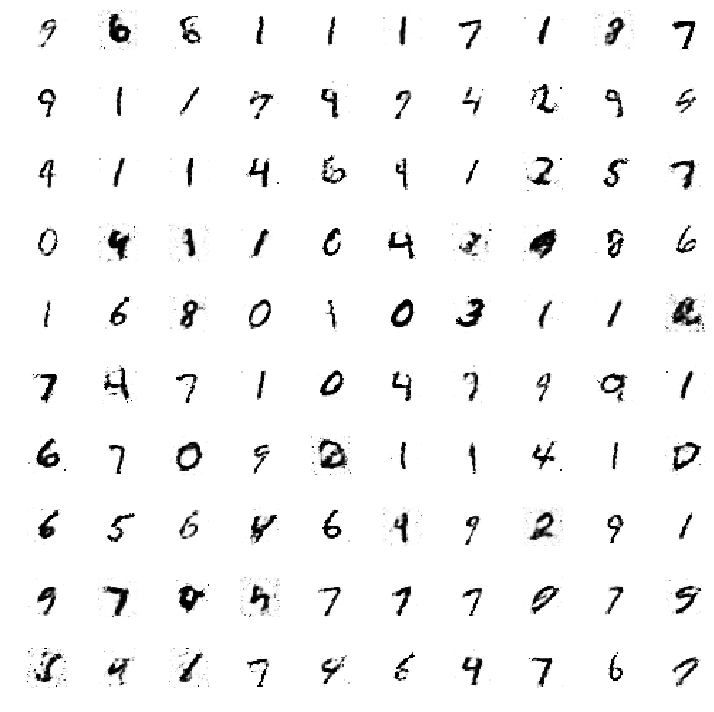

  0%|          | 2/468 [00:00<00:31, 14.90it/s]

--------------- Epoch 37 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.60it/s]


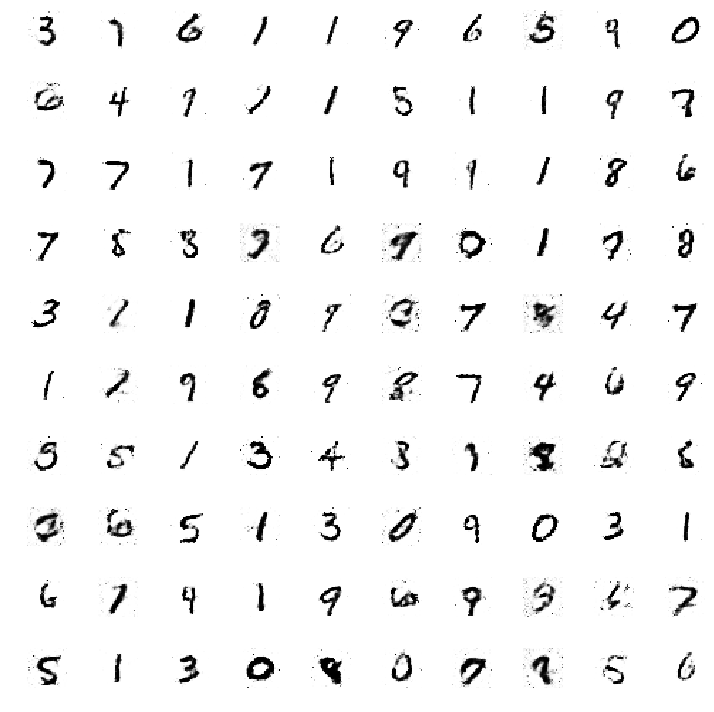

  0%|          | 2/468 [00:00<00:32, 14.18it/s]

--------------- Epoch 38 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.42it/s]


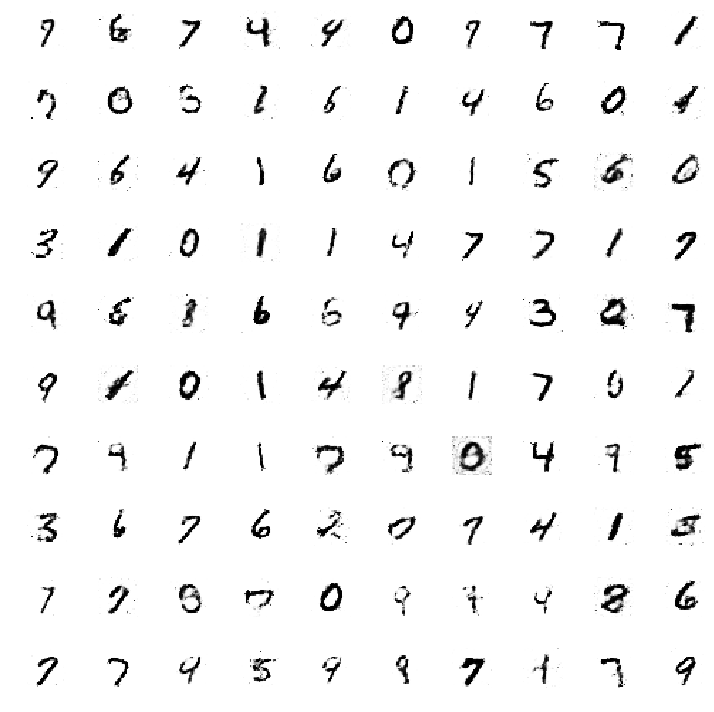

  0%|          | 2/468 [00:00<00:32, 14.45it/s]

--------------- Epoch 39 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.41it/s]


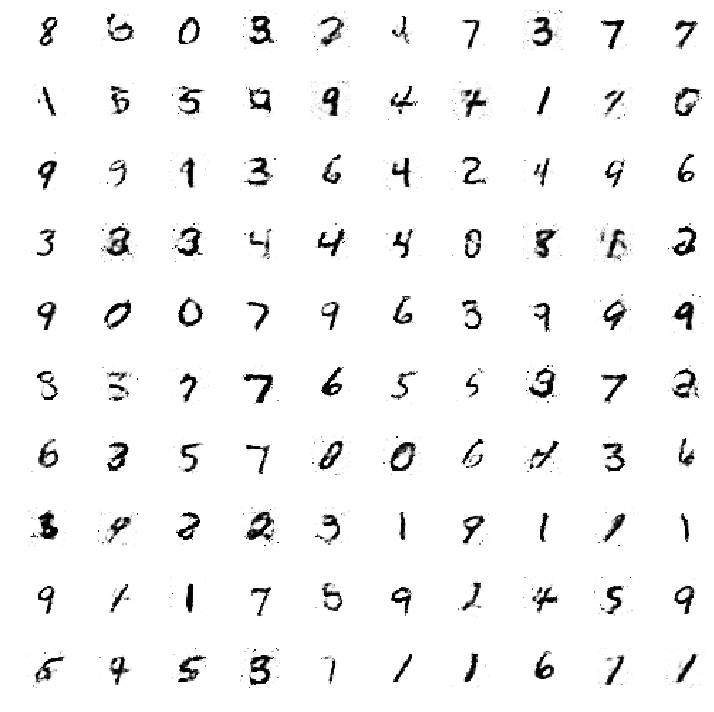

  0%|          | 2/468 [00:00<00:31, 14.94it/s]

--------------- Epoch 40 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.49it/s]


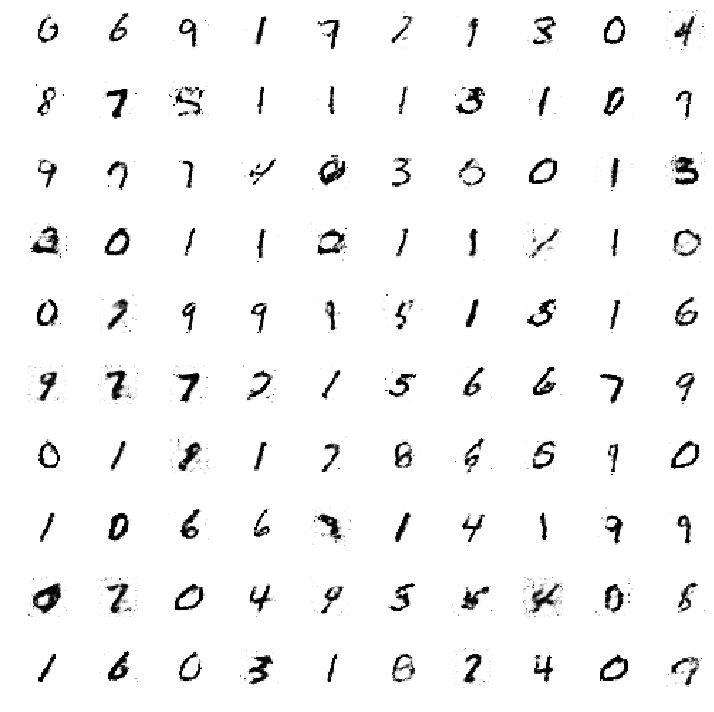

  0%|          | 2/468 [00:00<00:32, 14.24it/s]

--------------- Epoch 41 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.51it/s]


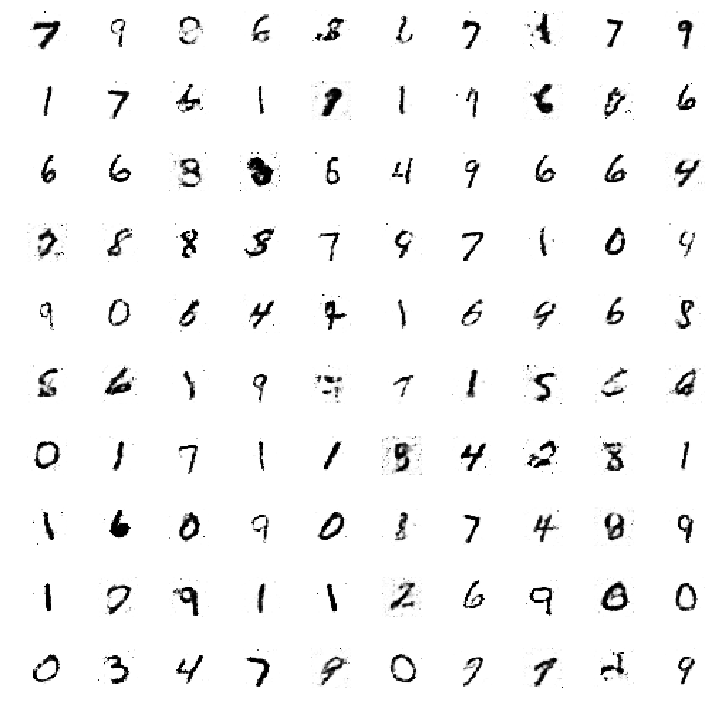

  0%|          | 2/468 [00:00<00:32, 14.52it/s]

--------------- Epoch 42 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.89it/s]


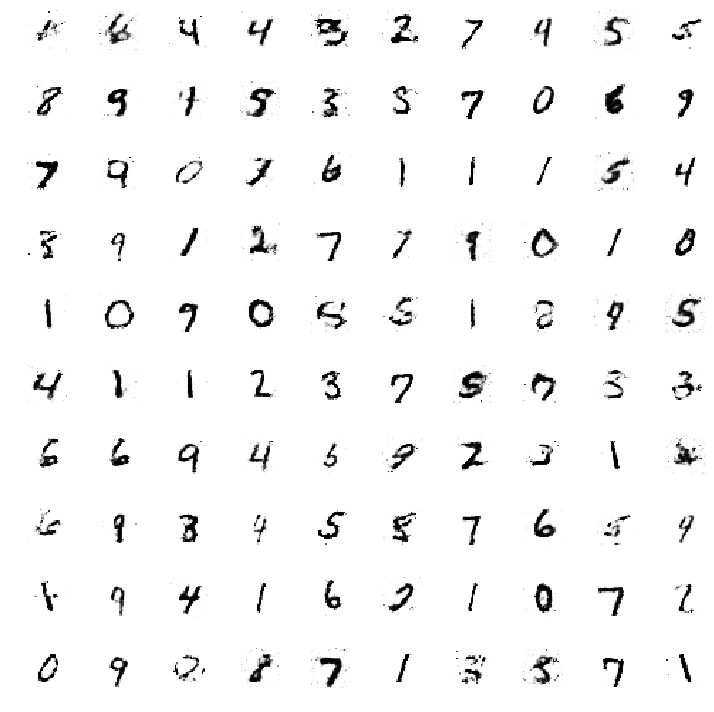

  0%|          | 2/468 [00:00<00:31, 14.59it/s]

--------------- Epoch 43 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.63it/s]


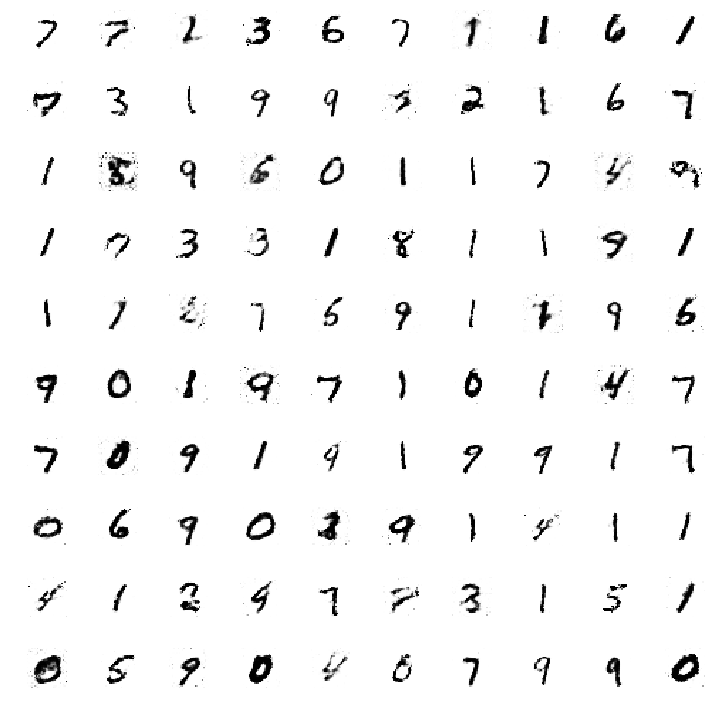

  0%|          | 2/468 [00:00<00:31, 14.76it/s]

--------------- Epoch 44 ---------------


100%|██████████| 468/468 [00:34<00:00, 14.05it/s]


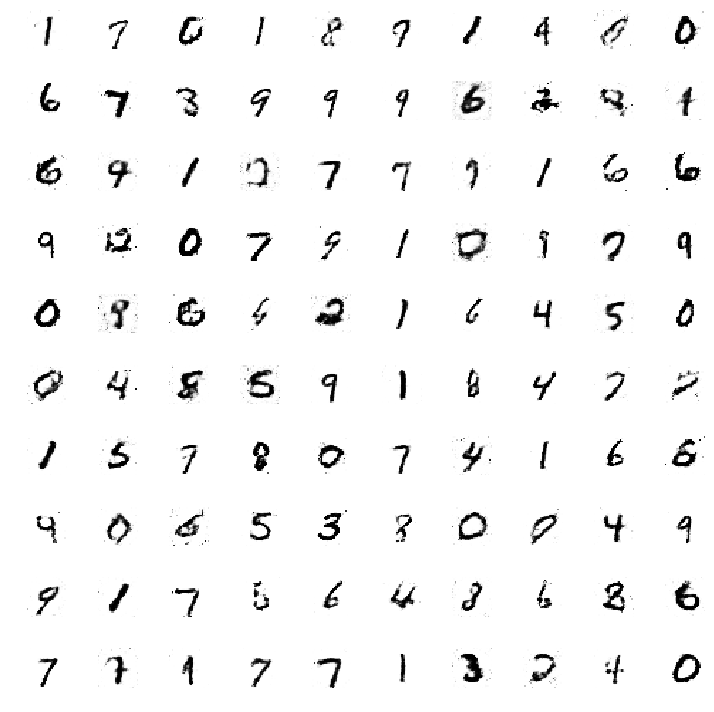

  0%|          | 2/468 [00:00<00:38, 12.17it/s]

--------------- Epoch 45 ---------------


100%|██████████| 468/468 [00:36<00:00, 11.73it/s]


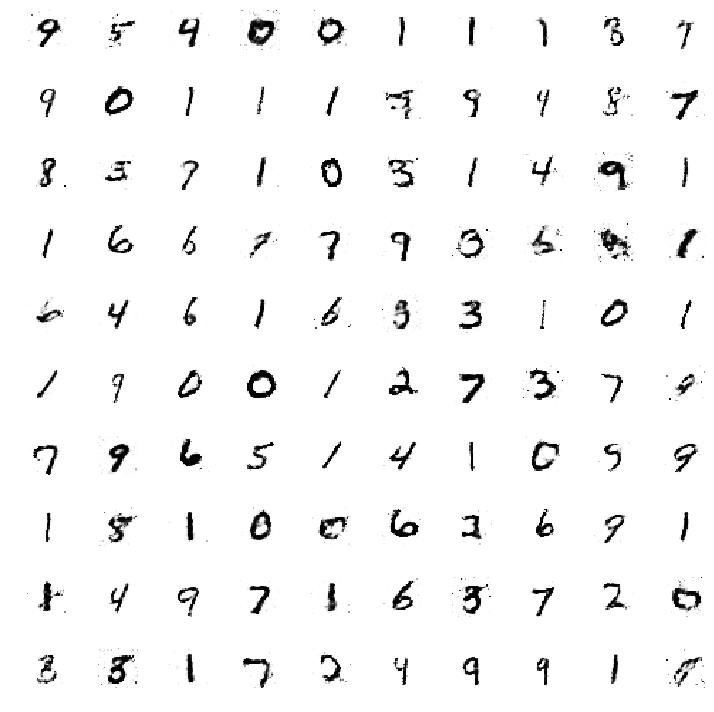

  0%|          | 2/468 [00:00<00:35, 13.26it/s]

--------------- Epoch 46 ---------------


100%|██████████| 468/468 [00:34<00:00, 14.19it/s]


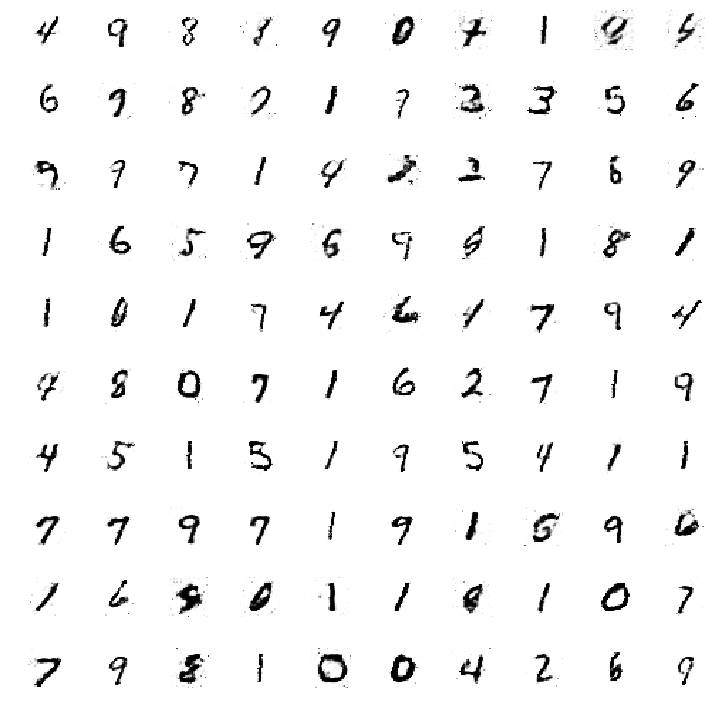

  0%|          | 2/468 [00:00<00:33, 14.11it/s]

--------------- Epoch 47 ---------------


100%|██████████| 468/468 [00:35<00:00, 14.26it/s]


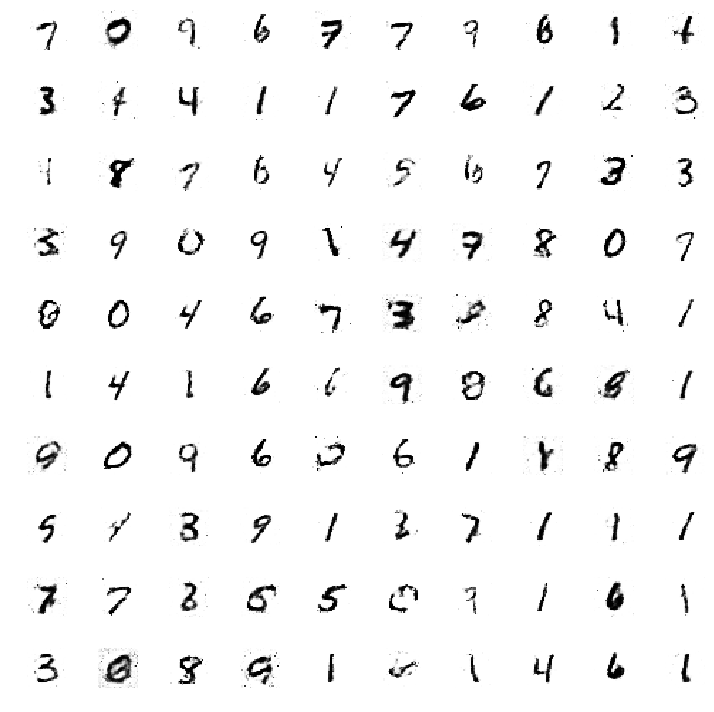

  0%|          | 2/468 [00:00<00:32, 14.18it/s]

--------------- Epoch 48 ---------------


100%|██████████| 468/468 [00:36<00:00, 13.46it/s]


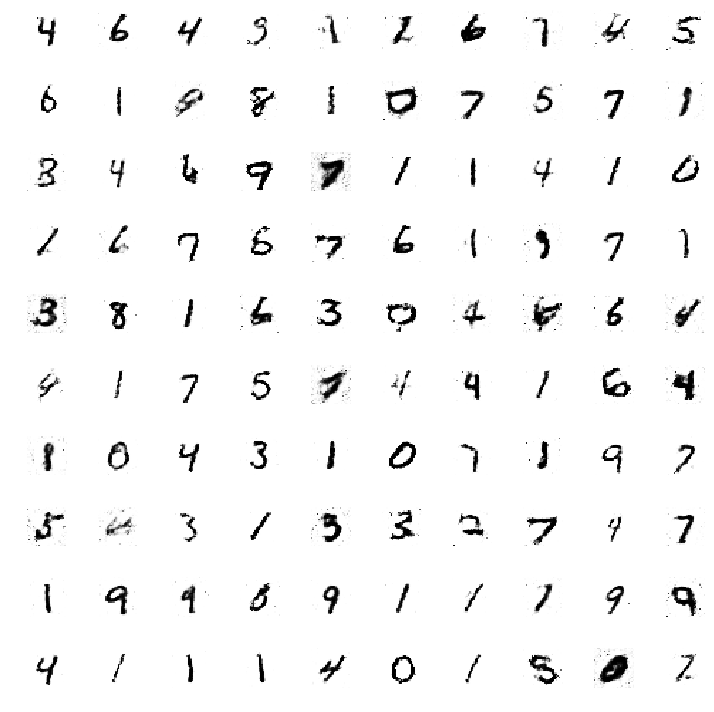

  0%|          | 2/468 [00:00<00:31, 14.62it/s]

--------------- Epoch 49 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.14it/s]


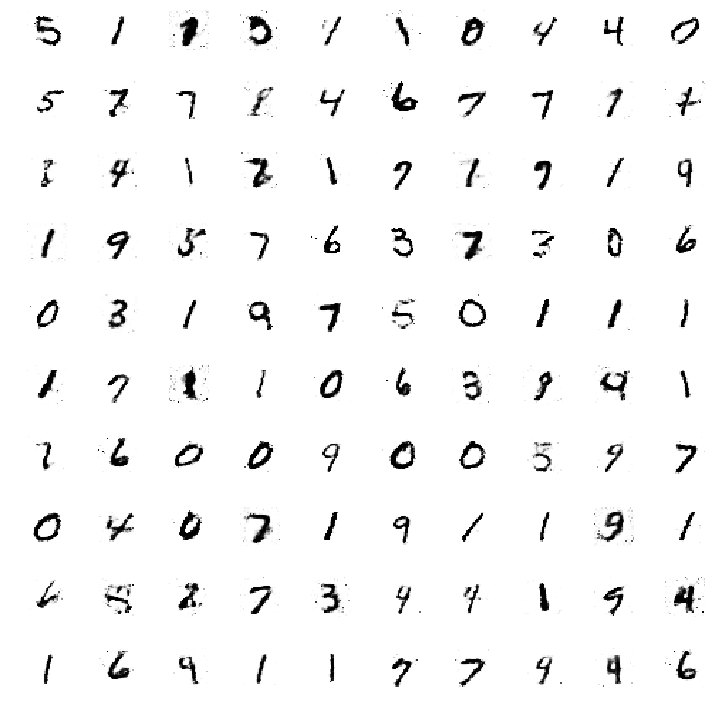

  0%|          | 2/468 [00:00<00:33, 13.86it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.51it/s]


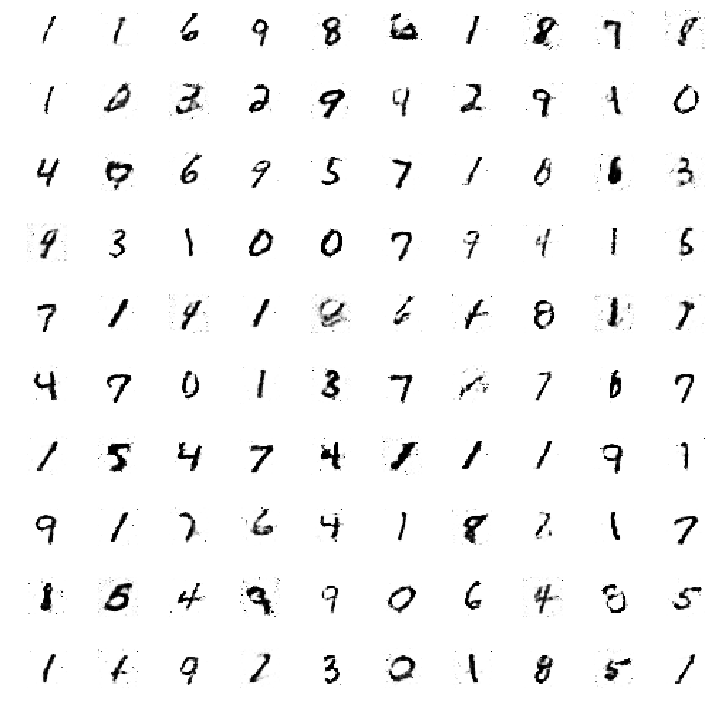

  0%|          | 2/468 [00:00<00:35, 13.11it/s]

--------------- Epoch 51 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.80it/s]


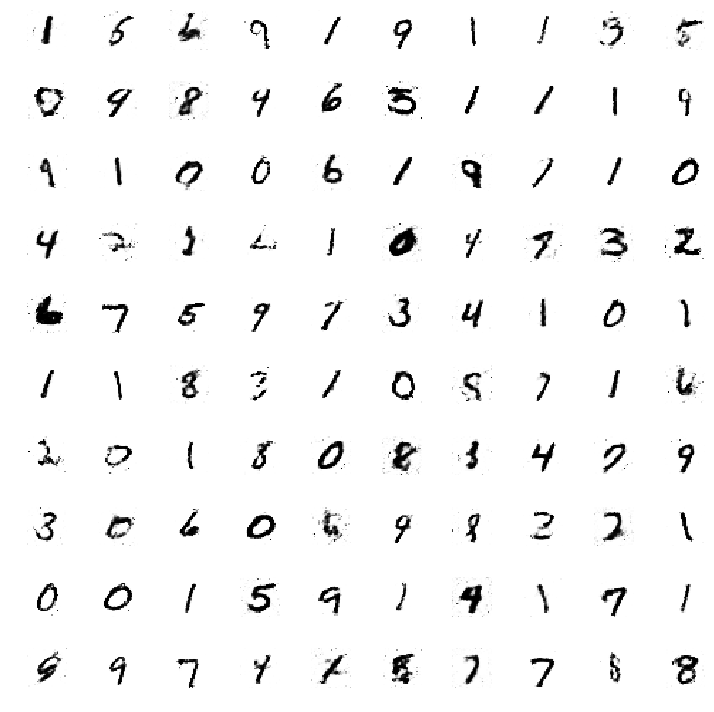

  0%|          | 2/468 [00:00<00:43, 10.75it/s]

--------------- Epoch 52 ---------------


100%|██████████| 468/468 [00:43<00:00, 13.64it/s]


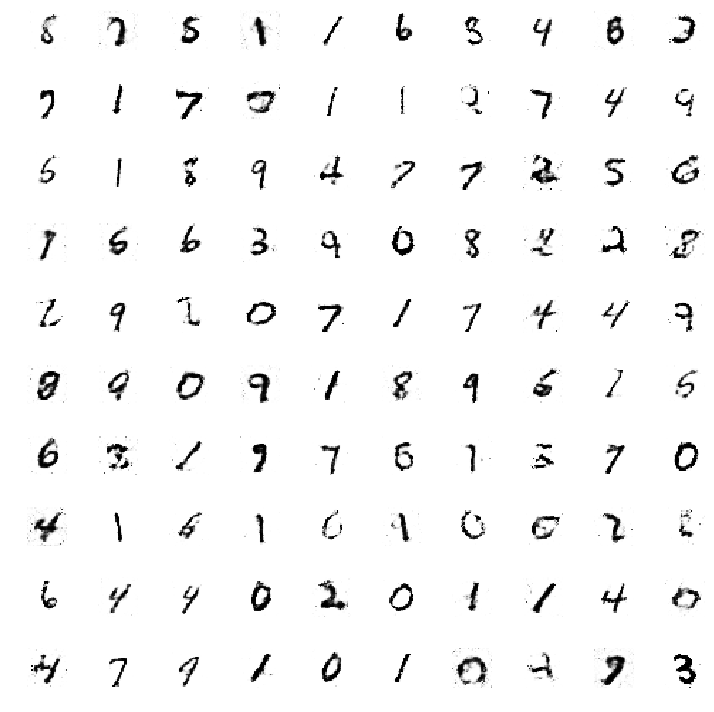

  0%|          | 2/468 [00:00<00:36, 12.86it/s]

--------------- Epoch 53 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.07it/s]


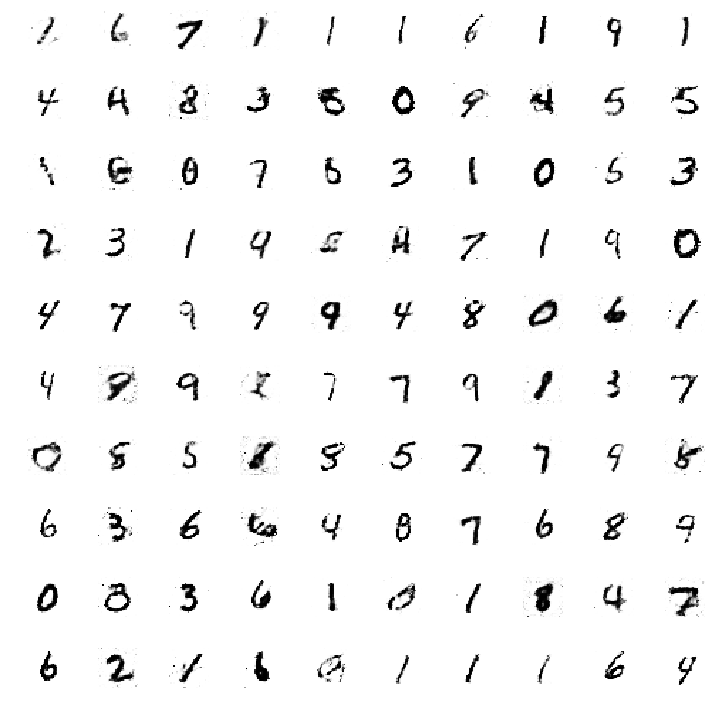

  0%|          | 2/468 [00:00<00:35, 13.18it/s]

--------------- Epoch 54 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.20it/s]


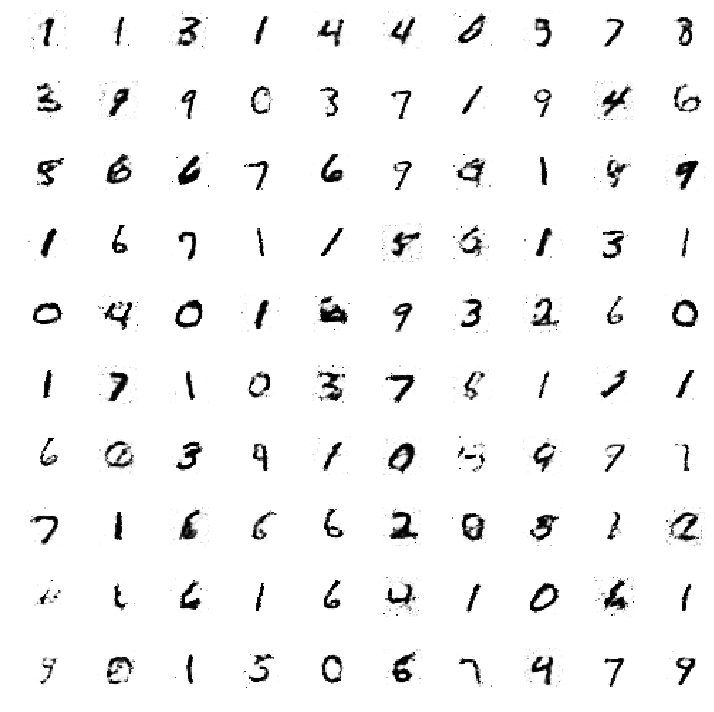

  0%|          | 2/468 [00:00<00:37, 12.56it/s]

--------------- Epoch 55 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.63it/s]


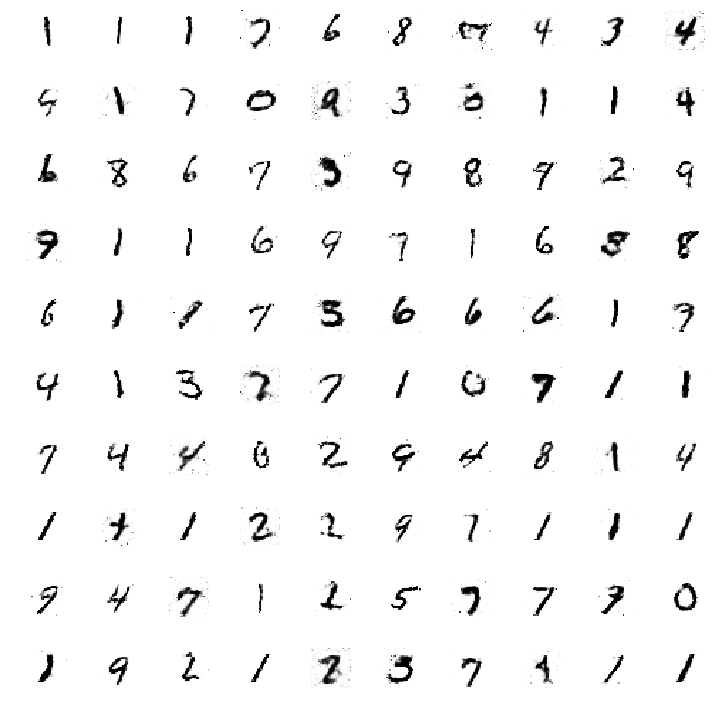

  0%|          | 2/468 [00:00<00:32, 14.26it/s]

--------------- Epoch 56 ---------------


100%|██████████| 468/468 [00:35<00:00, 12.82it/s]


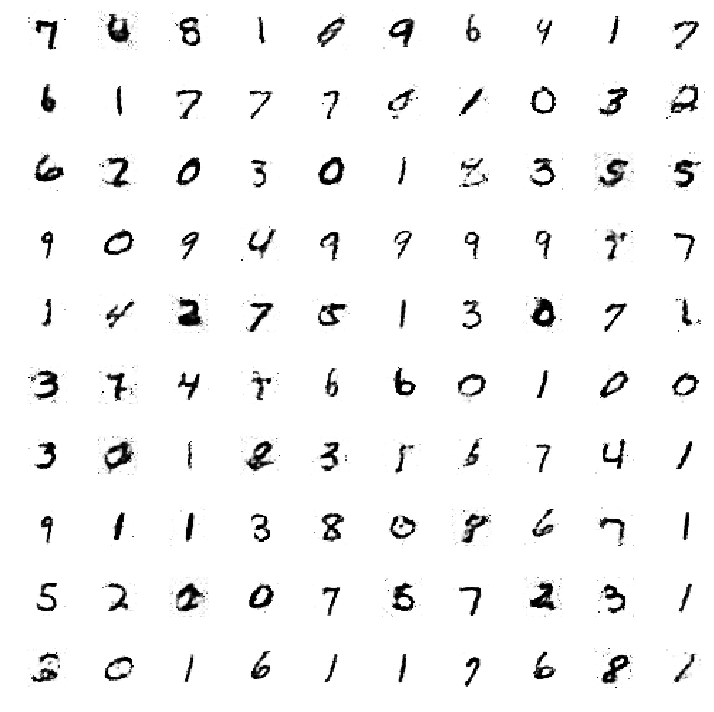

  0%|          | 2/468 [00:00<00:39, 11.66it/s]

--------------- Epoch 57 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.49it/s]


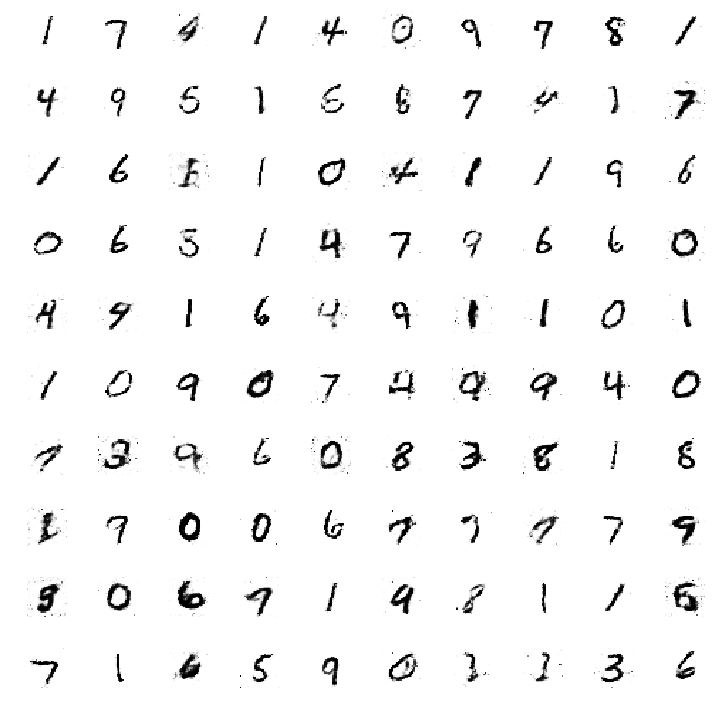

  0%|          | 2/468 [00:00<00:33, 14.04it/s]

--------------- Epoch 58 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.51it/s]


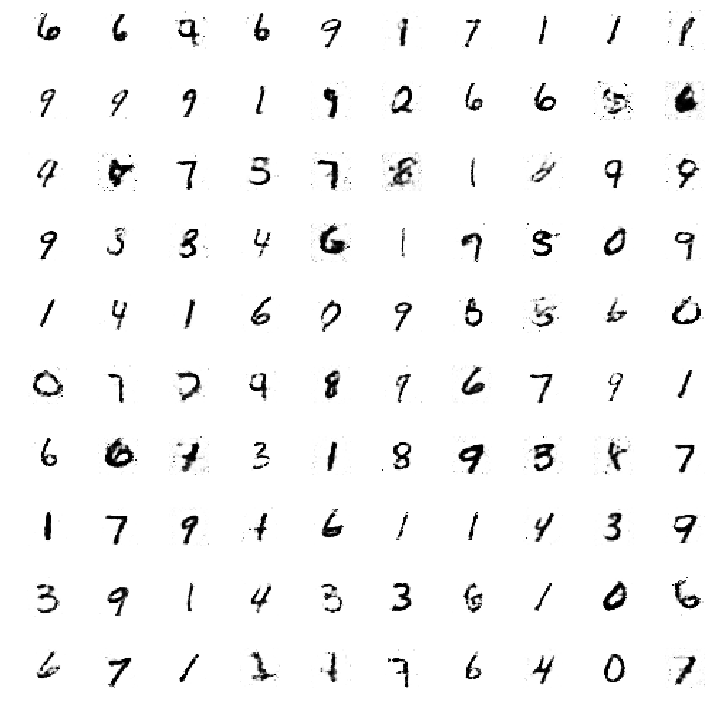

  0%|          | 2/468 [00:00<00:31, 14.80it/s]

--------------- Epoch 59 ---------------


100%|██████████| 468/468 [00:34<00:00, 14.15it/s]


In [ ]:
epochs = 1000
batchSize = 128

train(epochs=epochs, batchSize=batchSize)

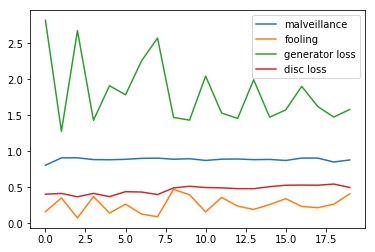

True

In [68]:
plotingLosses(mLosses, fLosses, gLosses, dLosses)

In [69]:
from keras.models import model_from_json

# load json and create model
json_file = open('models/gan10epochs.json', 'r')
loaded_disc = json_file.read()
json_file.close()
loaded_disc = model_from_json(loaded_disc)
# load weights into new model
loaded_disc.load_weights("models/modelGAN10epochs.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
# Optimizer
oldadam = Adam(lr=0.0002, beta_1=0.5)

loaded_disc.compile(loss='binary_crossentropy', optimizer=oldadam, metrics=["accuracy"])


Loaded model from disk


(array([ 8., 18., 18., 10.,  9., 11.,  1., 11.,  9.,  5.]),
 array([0.09089664, 0.17624615, 0.26159567, 0.34694517, 0.43229467,
        0.51764417, 0.60299367, 0.6883432 , 0.7736927 , 0.8590422 ,
        0.9443917 ], dtype=float32),
 <a list of 10 Patch objects>)

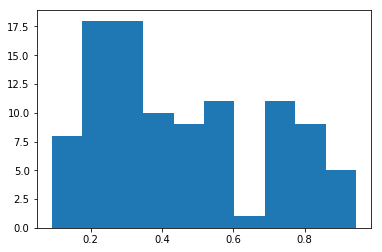

In [70]:
plt.hist(loaded_disc.predict(generatedImages))

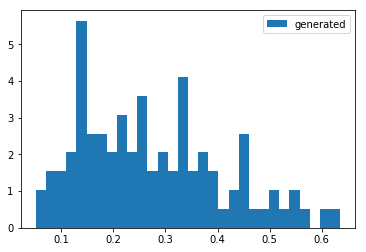

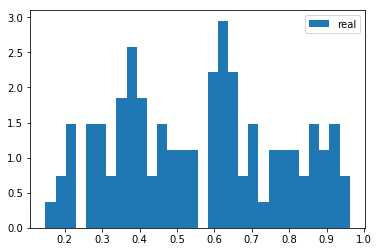

In [71]:
examples = 100
noise = np.random.normal(0, 1, size=[examples, randomDim])
generatedImages = generator.predict(noise)
realImages = X_test[:examples].reshape(100,28*28)
gI = discriminator.predict(generatedImages)
rI = discriminator.predict(realImages)
plt.hist(gI, bins=30, label="generated", normed=True)
plt.legend()
plt.show()
plt.close()
plt.hist(rI, bins=30,label="real", normed=True)
plt.legend()
plt.show()
plt.close()

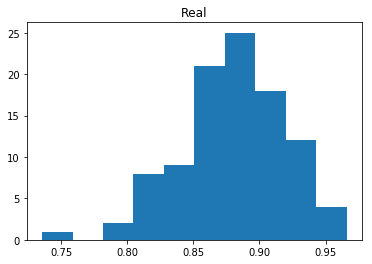

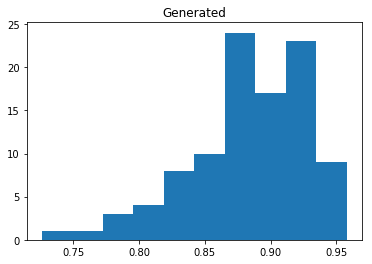

In [72]:
plt.hist([malveillance(r) for r in realImages])
plt.title("Real")
plt.show()
plt.close()
plt.hist([malveillance(g) for g in generatedImages])
plt.title("Generated")
plt.show()
plt.close()

In [73]:
evaluateGeneratedImages(generator, 100)

NameError: name 'evaluateGeneratedImages' is not defined